<a href="https://colab.research.google.com/github/matthiasplum/CosmicRayML-Masterclass/blob/main/IceTop_like_cosmicray_surfacedetector_simulation_and_CNN_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Air Shower Reconstruction with IceTop Detector Using Convolutional Neural Networks
High-energy cosmic rays, originating from astrophysical sources, interact with Earth's atmosphere to create extensive air showers. These air showers are cascades of secondary particles that propagate through the atmosphere and can be detected by ground-based observatories such as the IceTop detector at the South Pole. Accurate reconstruction of air shower properties—such as the energy, impact point, and arrival direction—is essential for understanding the origin and nature of these cosmic rays.

The IceTop detector, part of the IceCube Neutrino Observatory, consists of an array of ice-Cherenkov tanks spread over a square kilometer on the surface of the Antarctic ice. Each tank records signals generated by the Cherenkov light emitted when secondary particles from air showers pass through the ice. The timing and intensity of these signals provide crucial information about the characteristics of the original cosmic ray.

Traditional methods for reconstructing air shower properties often rely on analytical and empirical techniques, which can be computationally intensive and limited by their assumptions and approximations. In recent years, machine learning, particularly deep learning, has emerged as a powerful tool for pattern recognition and regression tasks, offering the potential to enhance the precision and efficiency of air shower reconstructions.

In this study, we propose using a Convolutional Neural Network (CNN) to reconstruct key parameters of air showers detected by IceTop. CNNs are well-suited for this task due to their ability to capture spatial hierarchies and patterns in data, making them effective for processing the grid-like layout of IceTop's detector array. By training the CNN on synthetic data that simulates the signals and timings recorded by the IceTop stations, we aim to predict the energy, impact point, and arrival direction of the primary cosmic rays.

The rest of this document details the generation of synthetic data for IceTop stations, the design and implementation of the CNN model, the normalization of input and output data to improve model performance, and the evaluation of the model's predictions against true values. Our results demonstrate the potential of deep learning techniques to advance the field of cosmic ray physics and provide new insights into the most energetic particles in the universe.








#Import python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate

#Set detector constants and define sample parameters

In [2]:
# Constants
NUM_STATIONS      = 81                                # Example number of stations (9x9 grid)
GRID_SIZE         = 1000                              # Grid size in meters (1000m x 1000m)
STATION_SPACING   = GRID_SIZE / np.sqrt(NUM_STATIONS)
NUM_SAMPLES       = 1_000                             # Number of synthetic events
SPEED_OF_LIGHT    = 3e8                               # Speed of the shower front in m/s (approx. speed of light)
CURVATURE_A_SCALE = 4.823e-4                          # a for the curvature effect in ns/m^2
CURVATURE_B_SCALE = 19.41                             # b for the curvature effect in ns
CURVATURE_SIGMA   = 118.1                             # sigma for the curvature Gaussian in m

R_REF = 125.  # Reference distance
BETA  = 2.5   # Beta
KAPPA = 0.303 # Kappa

#Set trigger level of IceTop tanks
TRIGGER_LEVEL = 0.125 # in log(VEM)

USE_TRIGGER_LEVEL = False # boolean if trigger condition should be applied

#Define station position and python function

In [3]:
# Generate station positions in a grid
stations_x, stations_y = np.meshgrid(np.linspace(0, GRID_SIZE, int(np.sqrt(NUM_STATIONS))),
                                     np.linspace(0, GRID_SIZE, int(np.sqrt(NUM_STATIONS))))
stations_positions = np.vstack([stations_x.ravel(), stations_y.ravel()]).T

def logS(perpendicular_distance,log_energy):
    log_s_ref = 1. * log_energy - 6.

    if perpendicular_distance!=0:
      log_s = log_s_ref *  (perpendicular_distance/R_REF)**(-BETA - np.log10(perpendicular_distance/R_REF))
    else:
      log_s = np.nan

    return log_s  # in log(VEM)

# Function to simulate an air shower hit on the IceTop stations
def simulate_air_shower(log_energy,impact_time,  impact_x, impact_y, azimuth, zenith):
    signals = []
    times = []
    triggered = []

    # Calculate the direction of the shower front in cartesian coordinates
    direction_cosines = np.array([np.sin(zenith) * np.cos(azimuth),
                                  np.sin(zenith) * np.sin(azimuth),
                                  np.cos(zenith)])

    # Calculate the distance from the stations to the impact point
    for pos in stations_positions:
        dist_x = pos[0] - impact_x
        dist_y = pos[1] - impact_y

        distance_vector = np.array([dist_x, dist_y, 0.])  # Distance vector from the impact point to the station

        dist = np.linalg.norm(distance_vector)  # Calculate the distance from the stations to the impact point

        # Calculate the perpendicular distance from the shower axis
        projection_length = np.dot(distance_vector, direction_cosines)
        projection_vector = projection_length * direction_cosines
        perpendicular_vector = distance_vector - projection_vector

        perpendicular_distance = np.linalg.norm(perpendicular_vector)

        # Calculate the signal strength in each station
        signal = logS(perpendicular_distance,log_energy)

        # Time delay based on the projection of the distance vector onto the direction cosines
        plane_wave_delay = np.dot(distance_vector,direction_cosines) / SPEED_OF_LIGHT * 1e9 # in ns

        # Curvature delay
        curvature_delay = (CURVATURE_A_SCALE * perpendicular_distance**2 + CURVATURE_B_SCALE * (1 - np.exp(-perpendicular_distance**2 / (2*CURVATURE_SIGMA**2))))

        total_time_delay = impact_time + plane_wave_delay + curvature_delay

        # Add the signal and time delay to the lists
        if USE_TRIGGER_LEVEL:
          if signal > TRIGGER_LEVEL:
            triggered.append(True)
            signals.append(signal)
            times.append(total_time_delay)
          else:
            triggered.append(False)
            signals.append(0)
            times.append(-100)
        else:
          signals.append(signal)
          times.append(total_time_delay)

    return np.array(signals), np.array(times), np.array(triggered)

#Generation of synthetic cosmic ray data

In [4]:
# Generate synthetic air shower data
X_signals   = []
X_times     = []
X_triggered = []
y_logS125   = []
y_energy    = []
y_impact    = []
y_direction = []

for _ in range(NUM_SAMPLES):
    log_energy  = np.random.uniform(6, 9)                                           # Energy in Log(E/GeV)
    impact_x    = np.random.uniform(0, GRID_SIZE)                                   # Shower core position x in m
    impact_y    = np.random.uniform(0, GRID_SIZE)                                   # Shower core position y in m
    azimuth     = np.random.uniform(np.deg2rad(0), np.deg2rad(360))                 # Shower direction azimuth in degree
    coszenith   = np.random.uniform(np.cos(np.deg2rad(0)), np.cos(np.deg2rad(60)))  # Shower direction cos(zenith) in degree

    signals, times, triggered  = simulate_air_shower(log_energy, 5000, impact_x, impact_y, azimuth, np.arccos(coszenith))

    X_signals.append(signals)
    X_times.append(times)
    X_triggered.append(triggered)
    y_logS125.append(logS(125,log_energy))
    y_energy.append(log_energy)
    y_impact.append([impact_x, impact_y])
    y_direction.append([coszenith,np.sin(azimuth),np.cos(azimuth)])

# Convert to numpy arrays
X_signals = np.array(X_signals)
X_times = np.array(X_times)
y_energy = np.array(y_energy)
y_impact = np.array(y_impact)
y_direction = np.array(y_direction)

#Plot some example showers (Can be skipped)

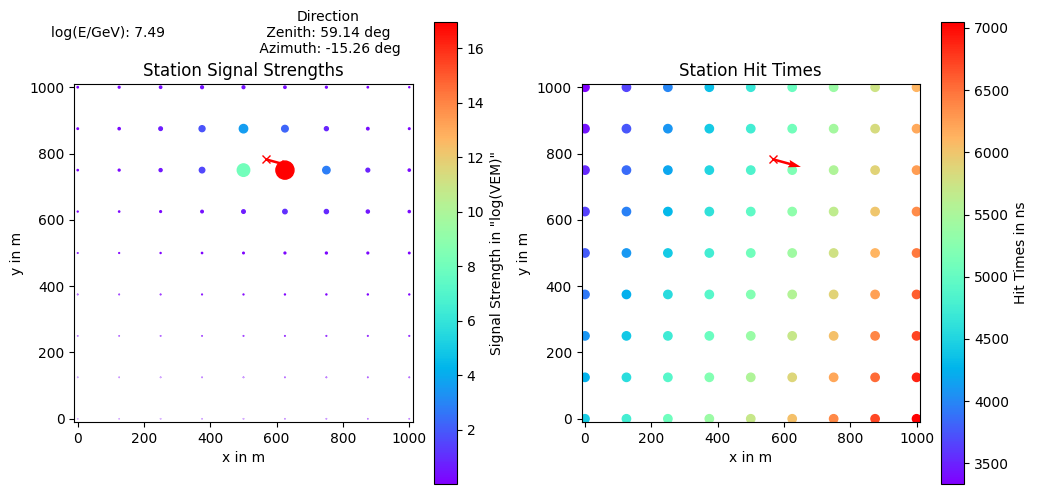

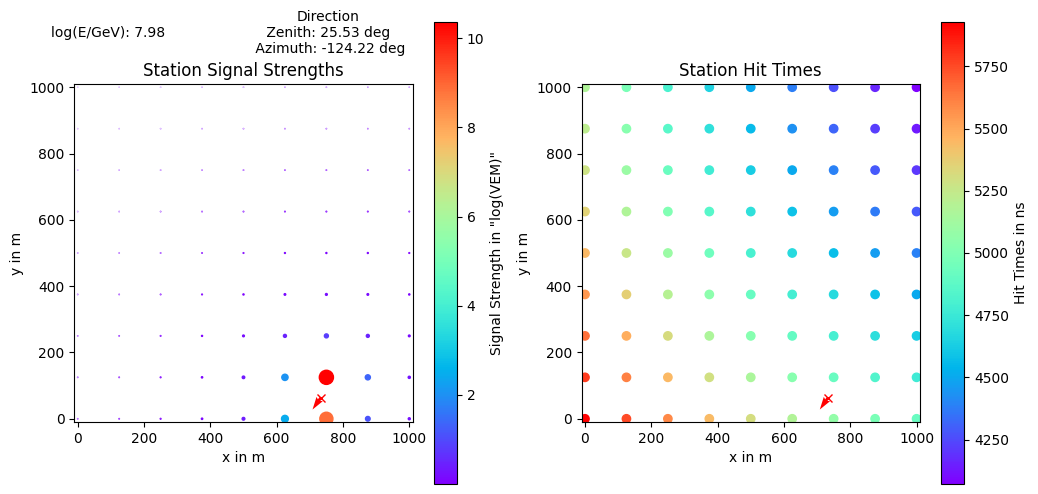

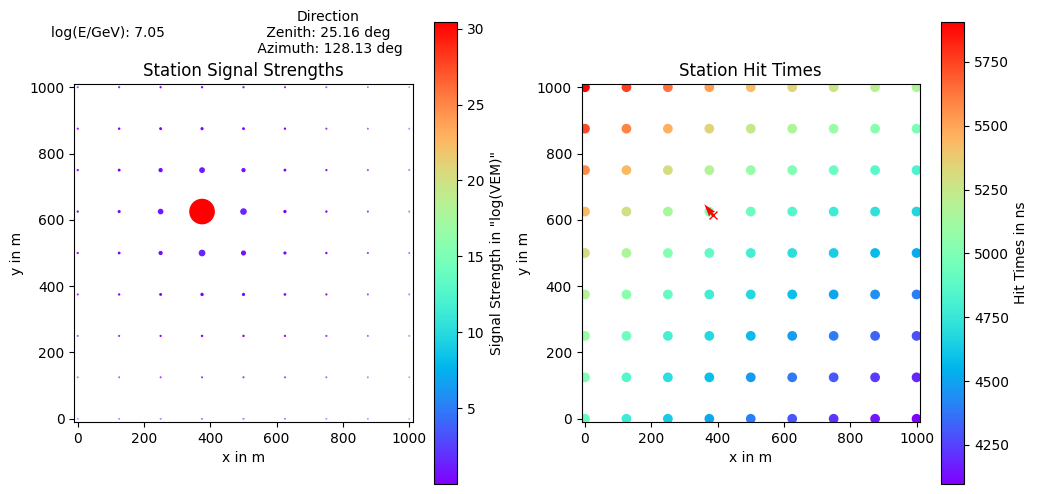

In [5]:
for example_shower in range(NUM_SAMPLES)[:3]:

  # Calculate the direction vector
  direction_vector = np.array([
      np.sin(np.arccos(y_direction[example_shower][0])) * y_direction[example_shower][2],
      np.sin(np.arccos(y_direction[example_shower][0])) * y_direction[example_shower][1],
      y_direction[example_shower][0]
  ])

  # For 2D projection, we use only the x and y components
  x_component = direction_vector[0]
  y_component = direction_vector[1]

  # Visualize examples
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].text(0.1, 1.15,\
             'log(E/GeV): '+str(round(y_energy[example_shower],2)),\
             ha='center', va='center', transform=ax[0].transAxes)
  ax[0].text(0.75, 1.15,\
             'Direction\n Zenith: ' +str(round(np.arccos(y_direction[example_shower][0])*180./np.pi,2))+' deg \n Azimuth: ' +str(round(np.arctan2(y_direction[example_shower][1],y_direction[example_shower][2])*180./np.pi,2))+' deg',\
             ha='center', va='center', transform=ax[0].transAxes)
  sc1 = ax[0].scatter(stations_positions[:, 0],\
                      stations_positions[:, 1],\
                      c=X_signals[example_shower],\
                      s=10*X_signals[example_shower],\
                      cmap='rainbow')
  fig.colorbar(sc1,ax=ax[0],label='Signal Strength in "log(VEM)"')
  ax[0].set_aspect('equal')
  ax[0].set_xlabel('x in m')
  ax[0].set_ylabel('y in m')
  ax[0].set_xlim(-10,GRID_SIZE+10)
  ax[0].set_ylim(-10,GRID_SIZE+10)
  ax[0].set_title('Station Signal Strengths')
  ax[0].plot(y_impact[example_shower][0],y_impact[example_shower][1], 'rx')
  ax[0].quiver(y_impact[example_shower][0],y_impact[example_shower][1],\
               100 * x_component,100 * y_component, angles='xy', scale_units='xy',\
               scale=1, color='r', label='Shower Axis')


  sc2 = ax[1].scatter(np.ma.masked_less(stations_positions[:, 0],0),\
                      np.ma.masked_less(stations_positions[:, 1],0),\
                      c=np.ma.masked_less(X_times[example_shower],0),\
                      cmap='rainbow')
  fig.colorbar(sc2,ax=ax[1],label='Hit Times in ns')
  ax[1].set_aspect('equal')
  ax[1].set_xlabel('x in m')
  ax[1].set_ylabel('y in m')
  ax[1].set_xlim(-10,GRID_SIZE+10)
  ax[1].set_ylim(-10,GRID_SIZE+10)
  ax[1].set_title('Station Hit Times')
  ax[1].plot(y_impact[example_shower][0],y_impact[example_shower][1], 'rx')
  ax[1].quiver(y_impact[example_shower][0],y_impact[example_shower][1],\
               100 * x_component,100 * y_component, angles='xy', scale_units='xy',\
               scale=1, color='r', label='Shower Axis')

  #for i, txt in enumerate(X_times[example_shower]):
      #ax.annotate(txt, (x[i], y[i]))
      #ax[1].annotate(round(txt,1),(stations_positions[:, 0][i]+10, stations_positions[:, 1][i]+10))
  plt.savefig(f'example_{example_shower}.png')
  plt.show()
  plt.close()




#Reshaping, splitting and scaling the input and the output variables

In [6]:
# Assuming X_signals and X_times are your features and y_energy, y_impact, y_direction are your labels
# Split the data into training and testing sets
X_signals_train, X_signals_test, X_times_train, X_times_test,\
y_energy_train, y_energy_test, y_impact_train, y_impact_test,\
y_direction_train, y_direction_test = train_test_split(X_signals, X_times, y_energy, y_impact, y_direction, test_size=0.2, random_state=42)

# Reshape the data to fit into a CNN: (num_samples, height, width, channels)
# Here, height and width are the dimensions of the grid (sqrt(NUM_STATIONS) x sqrt(NUM_STATIONS))
height, width = int(np.sqrt(NUM_STATIONS)), int(np.sqrt(NUM_STATIONS))

# Normalize the input features
scaler_signals  = StandardScaler()
scaler_times    = StandardScaler()

X_signals_train = scaler_signals.fit_transform(X_signals_train.reshape(-1, NUM_STATIONS)).reshape(-1, height, width, 1)
X_signals_test  = scaler_signals.transform(X_signals_test.reshape(-1, NUM_STATIONS)).reshape(-1, height, width, 1)
X_times_train   = scaler_times.fit_transform(X_times_train.reshape(-1, NUM_STATIONS)).reshape(-1, height, width, 1)
X_times_test    = scaler_times.transform(X_times_test.reshape(-1, NUM_STATIONS)).reshape(-1, height, width, 1)

# Stack the signals and times to create a two-channel input
X_train = np.concatenate([X_signals_train, X_times_train], axis=-1)
X_test  = np.concatenate([X_signals_test, X_times_test], axis=-1)

# Normalize the output targets
scaler_energy     = StandardScaler()
scaler_impact     = StandardScaler()
scaler_direction  = StandardScaler()

y_energy_train = scaler_energy.fit_transform(y_energy_train.reshape(-1, 1))
y_energy_test = scaler_energy.transform(y_energy_test.reshape(-1, 1))
y_impact_train = scaler_impact.fit_transform(y_impact_train)
y_impact_test = scaler_impact.transform(y_impact_test)
y_direction_train = scaler_direction.fit_transform(y_direction_train)
y_direction_test = scaler_direction.transform(y_direction_test)

#Creating the CNN model

In [7]:
# Define the input
input_layer = Input(shape=(height, width, 2))

# Convolutional layers
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)

conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)

# Flatten the output
flatten = Flatten()(pool3)

# Fully connected layers for energy, impact point, and arrival direction
dense1 = Dense(256, activation='relu')(flatten)
energy_output = Dense(1, name='energy_output')(dense1)

dense2 = Dense(256, activation='relu')(flatten)
impact_output = Dense(2, name='impact_output')(dense2)

dense3 = Dense(256, activation='relu')(flatten)
direction_output = Dense(3, name='direction_output')(dense3)

# Combine into a single model
model = Model(inputs=input_layer, outputs=[energy_output, impact_output, direction_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'energy_output': 'mse', 'impact_output': 'mse', 'direction_output': 'mse'},
              metrics={'energy_output': 'mae', 'impact_output': 'mae', 'direction_output': 'mae'})

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9, 9, 2)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 9, 9, 32)       │            608 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 5, 5, 32)       │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 5, 5, 64)       │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 3, 3, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 3, 3, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 2, 2, 128)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 512)            │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ energy_output (Dense)     │ (None, 1)              │            257 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ impact_output (Dense)     │ (None, 2)              │            514 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ direction_output (Dense)  │ (None, 3)              │            771 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 488,486 (1.86 MB)

 Trainable params: 488,486 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Visualize the model architecture
#plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
# Train the model
history = model.fit(X_train,
                    {'energy_output': y_energy_train, 'impact_output': y_impact_train, 'direction_output': y_direction_train},
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2)

# Save the model
#model.save('icetop_cnn_model.keras')

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - direction_output_mae: 0.8882 - energy_output_mae: 0.8464 - impact_output_mae: 0.8688 - loss: 2.9820 - val_direction_output_mae: 0.8309 - val_energy_output_mae: 0.7801 - val_impact_output_mae: 0.7681 - val_loss: 2.5158
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - direction_output_mae: 0.8335 - energy_output_mae: 0.7982 - impact_output_mae: 0.7503 - loss: 2.5294 - val_direction_output_mae: 0.8023 - val_energy_output_mae: 0.7625 - val_impact_output_mae: 0.6372 - val_loss: 2.2207
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - direction_output_mae: 0.7942 - energy_output_mae: 0.7652 - impact_output_mae: 0.6539 - loss: 2.2146 - val_direction_output_mae: 0.7300 - val_energy_output_mae: 0.7051 - val_impact_output_mae: 0.5302 - val_loss: 1.8313
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - direction_output_mae: 0.7224 - energy_output_mae: 0.7131 - impact_output_mae: 0.5533 - loss: 1.8750 - val_direction_output_mae: 0.6370 - v

In [10]:
# Evaluate the model on the test set
loss, energy_loss, impact_loss, direction_loss = model.evaluate(X_test,
                {'energy_output': y_energy_test, 'impact_output': y_impact_test, 'direction_output': y_direction_test})

print(f"Test Loss: {loss}")
print(f"Energy Loss: {energy_loss}")
print(f"Impact Loss: {impact_loss}")
print(f"Direction Loss: {direction_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - direction_output_mae: 0.3988 - energy_output_mae: 0.3499 - impact_output_mae: 0.3439 - loss: 0.8212 
Test Loss: 0.7816711664199829
Energy Loss: 0.39004722237586975
Impact Loss: 0.3509494662284851
Direction Loss: 0.33668002486228943


dict_keys(['direction_output_mae', 'energy_output_mae', 'impact_output_mae', 'loss', 'val_direction_output_mae', 'val_energy_output_mae', 'val_impact_output_mae', 'val_loss'])


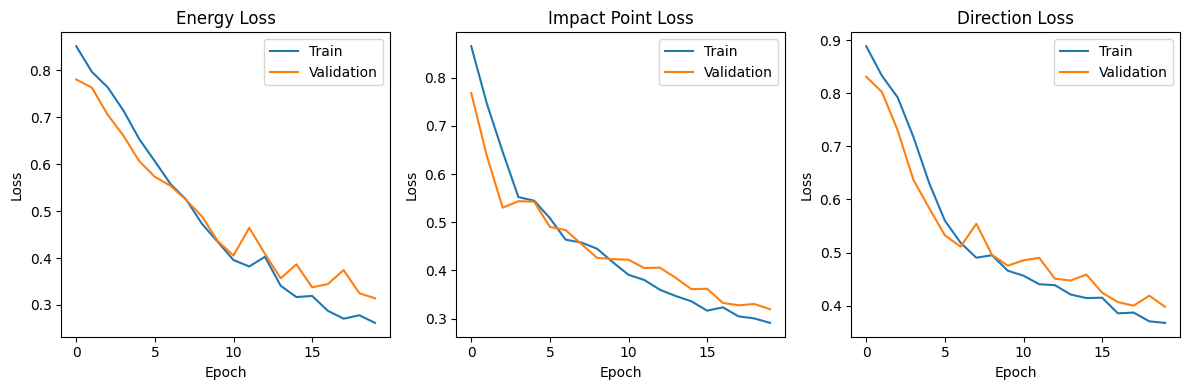

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

print(history.history.keys())

plt.subplot(1, 3, 1)
plt.plot(history.history['energy_output_mae'])
plt.plot(history.history['val_energy_output_mae'])
plt.title('Energy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 3, 2)
plt.plot(history.history['impact_output_mae'])
plt.plot(history.history['val_impact_output_mae'])
plt.title('Impact Point Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history.history['direction_output_mae'])
plt.plot(history.history['val_direction_output_mae'])
plt.title('Direction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
# Get predictions from the model
y_pred = model.predict(X_test)

# Separate the predictions
y_energy_pred = scaler_energy.inverse_transform(y_pred[0])
y_impact_pred = scaler_impact.inverse_transform(y_pred[1])
y_direction_pred = scaler_direction.inverse_transform(y_pred[2])

# Inverse transform the true values
y_energy_test_inv = scaler_energy.inverse_transform(y_energy_test)
y_impact_test_inv = scaler_impact.inverse_transform(y_impact_test)
y_direction_test_inv = scaler_direction.inverse_transform(y_direction_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


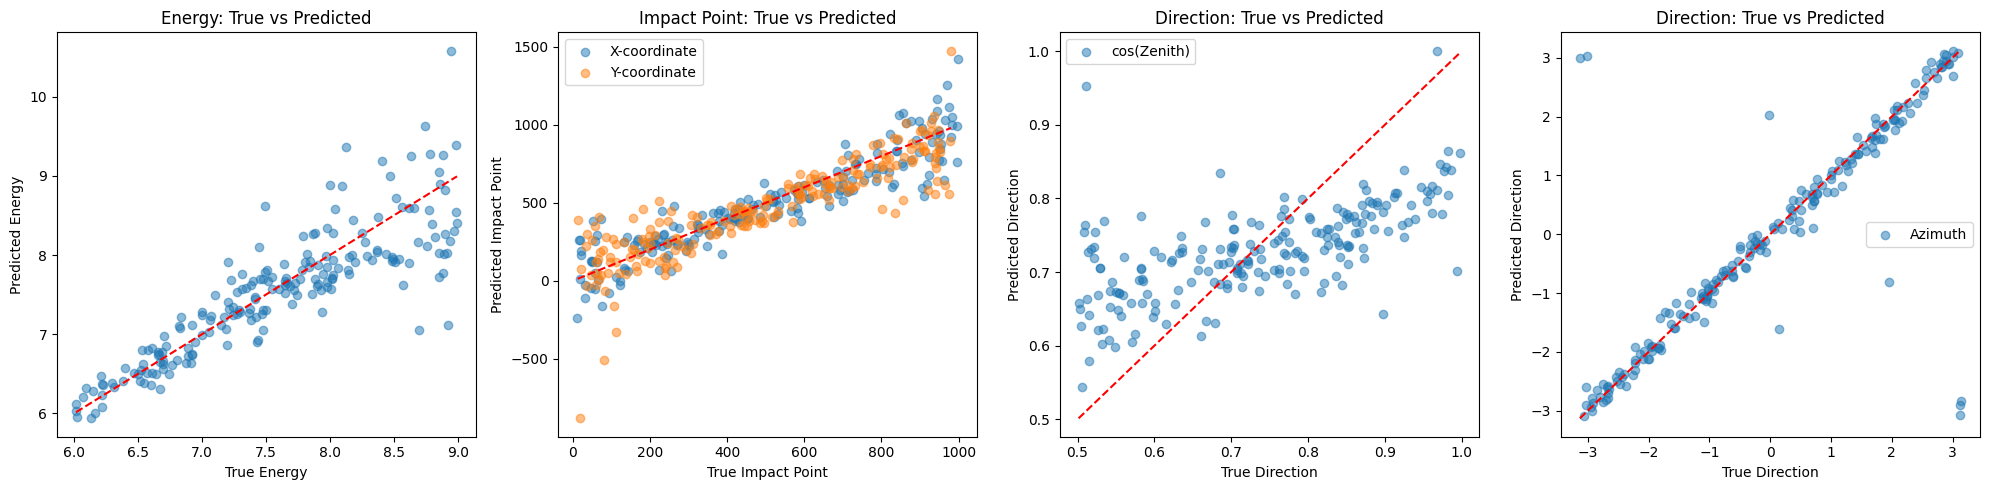

In [18]:
# Plot Energy Predictions vs True Values
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.scatter(y_energy_test_inv, y_energy_pred, alpha=0.5)
plt.plot([min(y_energy_test_inv),max(y_energy_test_inv)],\
         [min(y_energy_test_inv),max(y_energy_test_inv)],\
         'r--')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('Energy: True vs Predicted')

# Plot Impact Point Predictions vs True Values
plt.subplot(1, 4, 2)
plt.scatter(y_impact_test_inv[:, 0], y_impact_pred[:, 0], alpha=0.5, label='X-coordinate')
plt.scatter(y_impact_test_inv[:, 1], y_impact_pred[:, 1], alpha=0.5, label='Y-coordinate')
plt.plot([min(y_impact_test_inv[:, 1]),max(y_impact_test_inv[:, 1])],\
         [min(y_impact_test_inv[:, 1]),max(y_impact_test_inv[:, 1])],\
         'r--')
plt.xlabel('True Impact Point')
plt.ylabel('Predicted Impact Point')
plt.title('Impact Point: True vs Predicted')
plt.legend()

# Plot Direction Predictions vs True Values
plt.subplot(1, 4, 3)
plt.scatter(y_direction_test_inv[:, 0], y_direction_pred[:, 0], alpha=0.5, label='cos(Zenith)')

plt.plot([min(y_direction_test_inv[:, 0]),max(y_direction_test_inv[:, 0])],\
         [min(y_direction_test_inv[:, 0]),max(y_direction_test_inv[:, 0])], \
         'r--')
plt.xlabel('True Direction')
plt.ylabel('Predicted Direction')
plt.title('Direction: True vs Predicted')
plt.legend()
# Plot Direction Predictions vs True Values
plt.subplot(1, 4, 4)
plt.scatter(np.arctan2(y_direction_test_inv[:, 1],y_direction_test_inv[:, 2]),\
            np.arctan2(y_direction_pred[:, 1],y_direction_pred[:, 2]),\
            alpha=0.5, label='Azimuth')
#plt.scatter(y_direction_test[:, 2], y_direction_pred[:, 2], alpha=0.5, label='cos(Azimuth)')
plt.plot([min(np.arctan2(y_direction_test_inv[:, 1],y_direction_test_inv[:, 2])),max(np.arctan2(y_direction_test[:, 1],y_direction_test[:, 2]))],\
         [min(np.arctan2(y_direction_test_inv[:, 1],y_direction_test_inv[:, 2])),max(np.arctan2(y_direction_test[:, 1],y_direction_test[:, 2]))],\
         'r--')

plt.xlabel('True Direction')
plt.ylabel('Predicted Direction')
plt.title('Direction: True vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()